### Post stack cubegeomtry *Geometry Polygon* validation and reporting - SDB 

In [1]:
"""Uncomment if running in Azure ML"""
import sys
sys.path.append(r'/mnt/batch/tasks/shared/LS_root/mounts/clusters/jopm/code/Users/JOPM/osdu_jopm_rottation')
sys.path

from utils.sdb_diskos_service import LandmarkService
from src.libs.osdu_service.osdu_http_client import OsduHttpClient
from dotenv import load_dotenv
import json
import os

load_dotenv()

True

In [2]:
"""
Utilities
"""

import json, os
import ast
import logging
import math
import pylab
import numpy as np
import pandas as pd
from shapely.geometry import Polygon
import matplotlib.patches as patches
import matplotlib.pyplot as plt

def get_attribute(record, attribute):
    keys = attribute.split(".")
    value = record
    for key in keys:
        value = value.get(key)
        if value is None:
            return None
    return value

def fix_json_string(json_string):
    parsed_data = ast.literal_eval(json_string)
    corrected_string = json.dumps(parsed_data)
    return corrected_string

def geometry_to_json(cube_geometry_record):
    geom_string = get_attribute(cube_geometry_record, "data.geometry")
    
    if geom_string:
        try:    
            geom_fixed_string = fix_json_string(geom_string)
            geom_json = json.loads(geom_fixed_string)
            return geom_json
        
        except json.JSONDecodeError as e:
            # error_position = e.pos
            # error_fragment = json_string[max(0, error_position - 10):error_position + 10]
            # print("JSONDecodeError: Error parsing JSON at position {}: {} - error: {}".format(error_position, error_fragment, e))
            return None
    return None

def is_valid_polygon(coordinates):
    if len(coordinates) < 3:
        return False

    polygon = Polygon(coordinates)
    validity = polygon.is_valid and not polygon.is_empty
    
    return validity

def fix_polygon(coordinates): 
     
    original_polygon = Polygon(coordinates)
    buffer_polygon = original_polygon.buffer(0)
    fixed_polygon = buffer_polygon.buffer(0)
    
    return list(fixed_polygon.exterior.coords)

def get_polygon_array(json_geometry):
    linestring = get_attribute(json_geometry, "linestringzm")

    if linestring and isinstance(linestring, list):
        lat = linestring[0].get("x")
        lon = linestring[0].get("y")
        return [[float(x), float(y)] for x, y in zip(lat, lon)]
    
    return None

def validate_geometry_polygon(json_geometry):

    original_flag = False
    fixed_flag = False
    invalid_flag = False

    orig_polygon_arr = get_polygon_array(json_geometry)
    
    if orig_polygon_arr is not None and len(orig_polygon_arr) > 2:
        if is_valid_polygon(orig_polygon_arr):
            original_flag = True

            logging.info("Valid geometry found in custom record")

            return json_geometry, original_flag, fixed_flag, invalid_flag
        
        logging.info("Invalid geometry found in custom record - attemptting to fixing it.")   
        fixed_polygon_arr = fix_polygon(orig_polygon_arr)
        
        if is_valid_polygon(fixed_polygon_arr):
            fixed_flag = True
            json_geometry["linestringzm"][0]["x"] = [pair[0] for pair in fixed_polygon_arr]
            json_geometry["linestringzm"][0]["y"] = [pair[1] for pair in fixed_polygon_arr]

            logging.info("Invalid geometry fixed succesfully.") 

            return json_geometry, original_flag, fixed_flag, invalid_flag

    invalid_flag = True
    logging.warning("Invalid geometry found in custom record - impossible to fix.") 
    
    return json_geometry, original_flag, fixed_flag, invalid_flag

def plot_plygon(pp):
    pylab.scatter([p[0] for p in pp],[p[1] for p in pp])
    pylab.xlim(min([p[0] for p in pp]), max([p[0] for p in pp]))
    pylab.gca().add_patch(patches.Polygon(pp,closed=False,fill=False))
    pylab.grid()
    pylab.show()

def plot_polygon(pp):
    x_coords, y_coords = zip(*pp)
    min_x, max_x = min(x_coords), max(x_coords)
    min_y, max_y = min(y_coords), max(y_coords)

    plt.scatter(x_coords, y_coords)
    # plt.xlim(min_x, max_x)
    # plt.ylim(min_y, max_y)
    plt.gca().add_patch(patches.Polygon(pp, closed=False, fill=False))
    plt.grid()
    plt.show()

def plot_scatter(df, size_by:str, coloy_by: str,  title: str, size=1):
    plt.scatter(
        df.index,
        df[size_by],
        s=df[size_by] * size,
        c=df[coloy_by].map({True: "blue", False: "red"})
    )

    plt.xlabel("Index")
    plt.ylabel("Coordinate pairs")
    plt.title(title)
    plt.grid()
    plt.show()

In [11]:
# last_run_date_time =None
last_run_date_time = "2023-06-14T09:10:16.945Z"
query_records_created_prior_latsrundate = True

osdu_env = "npequinor-test"
source = "sdb"
# source = "diskos"

osdu_client = OsduHttpClient(osdu_env, client_type="token-client")

In [12]:
"""
Let's first request the custom records poststackcubegeometries custom records from OSDU to run the check in all geometries.
"""

schema_kind = f"eqnr:iEnergy-{source}:poststackcubegeometries:1.0.0"
search_payload =  {
    "kind": schema_kind
    # "returnedFields": ["id"],
    # "query": f"data.seismicPoststackDatasetId:\"{dataset_id}\""
}
osdu_cutom_geometry_records = osdu_client.app_query_returning_json("search/v2/query_with_cursor", search_payload)

print(f">> Retrieved {len(osdu_cutom_geometry_records)} records from OSDU:{osdu_env} of kind {schema_kind}")

>> Retrieved 18824 records from OSDU:npequinor-test of kind eqnr:iEnergy-sdb:poststackcubegeometries:1.0.0


In [13]:
"""Lets do some validation checks on the geometry polygons."""

polygon_summary = []

for geometry_record in osdu_cutom_geometry_records:
    dataset_id = get_attribute(geometry_record, "data.seismicPoststackDatasetId")
    related_dataset_id = f"{osdu_env}:seismicpoststackdatasets:{dataset_id}"
    related_seismic_trace_id = f"{osdu_env}:work-product-component--SeismicTraceData:{dataset_id}"

    try:
        geometry_json = geometry_to_json(geometry_record)
        polygon_arr = get_polygon_array(geometry_json)
        unique_subarrays, _ = np.unique(np.array(polygon_arr), axis=0, return_index=True)
        json_geometry, original_flag, fixed_flag, invalid_flag = validate_geometry_polygon(geometry_json)

        record_summary = {
            "cube_related_gemometry_id": geometry_record.get('id'),
            "coordinate_pairs": len(polygon_arr),
            "unique_coordinate_pairs": len(unique_subarrays),
            "is_original_valid" : original_flag,
            "is_fixable_flag" : fixed_flag,
            "is_invalid_flag" : invalid_flag,
            "related_dataset_id": related_dataset_id,
            "related_seismictrace_id": related_seismic_trace_id
        }

        polygon_summary.append(record_summary)
    except Exception as ex:
        logging.error("Error occurred while processing record %s: %s", related_dataset_id, str(ex))

        polygon_arr = None; unique_subarrays = None; original_flag=False; fixed_flag=False; invalid_flag=True
        
        record_summary = {
            "cube_related_gemometry_id": geometry_record.get('id'),
            "coordinate_pairs": None,
            "unique_coordinate_pairs": None,
            "is_original_valid" : original_flag,
            "is_fixable_flag" : fixed_flag,
            "is_invalid_flag" : invalid_flag,
            "related_dataset_id": related_dataset_id,
            "related_seismictrace_id": related_seismic_trace_id
        }

        polygon_summary.append(record_summary)

ERROR:root:Error occurred while processing record npequinor-test:seismicpoststackdatasets:31367077: 'NoneType' object has no attribute 'get'
ERROR:root:Error occurred while processing record npequinor-test:seismicpoststackdatasets:466285738: 'NoneType' object has no attribute 'get'


In [14]:
"""Check results as dataframe"""

df = pd.DataFrame.from_dict(polygon_summary)
df.head()

,cube_related_gemometry_id,coordinate_pairs,unique_coordinate_pairs,is_original_valid,is_fixable_flag,is_invalid_flag,related_dataset_id,related_seismictrace_id
0,npequinor-test:poststackcubegeometries:1657864934,7.0,6.0,True,False,False,npequinor-test:seismicpoststackdatasets:31368362,npequinor-test:work-product-component--Seismic...
1,npequinor-test:poststackcubegeometries:1657860567,25.0,24.0,True,False,False,npequinor-test:seismicpoststackdatasets:31363688,npequinor-test:work-product-component--Seismic...
2,npequinor-test:poststackcubegeometries:1657863733,5.0,4.0,True,False,False,npequinor-test:seismicpoststackdatasets:31367063,npequinor-test:work-product-component--Seismic...
3,npequinor-test:poststackcubegeometries:1657863838,16.0,15.0,True,False,False,npequinor-test:seismicpoststackdatasets:31367178,npequinor-test:work-product-component--Seismic...
4,npequinor-test:poststackcubegeometries:1657861737,30.0,29.0,True,False,False,npequinor-test:seismicpoststackdatasets:31364926,npequinor-test:work-product-component--Seismic...


In [15]:
print(
    f"""
    Total number of posstackcubegeometry records analyzed (polygons): {df.shape[0]},
    
    Original polygons that seem valid: {df[df.is_original_valid == True].shape[0]},
    Original polygons that seem invalid: {df[df.is_original_valid == False].shape[0]},
        - Original invalid polygons that seem fixable: {df[(df.is_original_valid == False) & (df.is_fixable_flag == True)].shape[0]},
        - Original invalid polygons that do not seem fixable: {df[(df.is_original_valid == False) & (df.is_fixable_flag == False)].shape[0]}
    """
)


    Total number of posstackcubegeometry records analyzed (polygons): 18824,
    
    Original polygons that seem valid: 18632,
    Original polygons that seem invalid: 192,
        - Original invalid polygons that seem fixable: 138,
        - Original invalid polygons that do not seem fixable: 54
    


In [16]:
df.head()

,cube_related_gemometry_id,coordinate_pairs,unique_coordinate_pairs,is_original_valid,is_fixable_flag,is_invalid_flag,related_dataset_id,related_seismictrace_id
0,npequinor-test:poststackcubegeometries:1657864934,7.0,6.0,True,False,False,npequinor-test:seismicpoststackdatasets:31368362,npequinor-test:work-product-component--Seismic...
1,npequinor-test:poststackcubegeometries:1657860567,25.0,24.0,True,False,False,npequinor-test:seismicpoststackdatasets:31363688,npequinor-test:work-product-component--Seismic...
2,npequinor-test:poststackcubegeometries:1657863733,5.0,4.0,True,False,False,npequinor-test:seismicpoststackdatasets:31367063,npequinor-test:work-product-component--Seismic...
3,npequinor-test:poststackcubegeometries:1657863838,16.0,15.0,True,False,False,npequinor-test:seismicpoststackdatasets:31367178,npequinor-test:work-product-component--Seismic...
4,npequinor-test:poststackcubegeometries:1657861737,30.0,29.0,True,False,False,npequinor-test:seismicpoststackdatasets:31364926,npequinor-test:work-product-component--Seismic...


In [10]:
df_original_invalid = df[(df.is_original_valid == False)]
df_original_invalid.is_fixable_flag.value_counts()

is_fixable_flag
True     343
False     33
Name: count, dtype: int64

In [9]:
"""Geometries that seem invalid and therefore will continue to fail to be indexed."""

df_original_invalid[df_original_invalid.is_fixable_flag == False].unique_coordinate_pairs.value_counts()

unique_coordinate_pairs
1.0    40
2.0    12
Name: count, dtype: int64

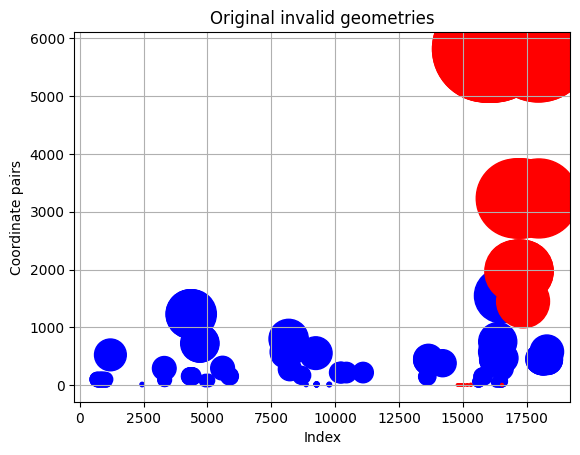

In [10]:
plot_scatter(df_original_invalid, "coordinate_pairs", "is_fixable_flag", "Original invalid geometries", size=1)

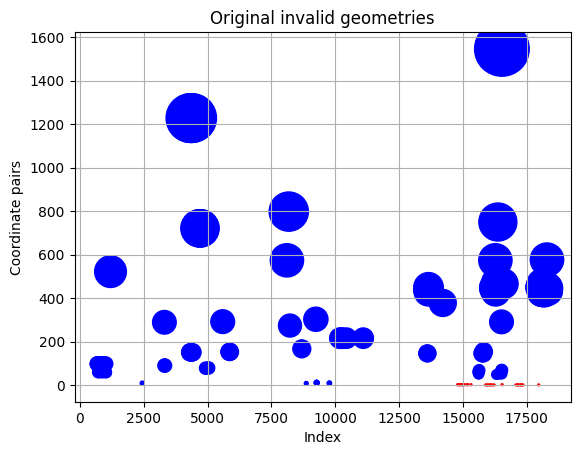

In [11]:
plot_scatter(df_original_invalid, "unique_coordinate_pairs", "is_fixable_flag", "Original invalid geometries", size=1)

In [12]:
"""
REASON:

Geometries that seem invalid and therefore will continue to fail to be indexed. Altought the polygons have tens or thousands of coordinates
they still represent lines or a single point and therefore cannot be considered polygons; reason why OSDU will continue to fail to index the
Seismic Trace records connected to this poststackcubegeometry records.

"""

'\nREASON:\n\nGeometries that seem invalid and therefore will continue to fail to be indexed. Altought the polygons have tens or thousands of coordinates\nthey still represent lines or a single point and therefore cannot be considered polygons; reason why OSDU will continue to fail to index the\nSeismic Trace records connected to this poststackcubegeometry records.\n\n'

##### Testing geometry fix and re-ingestion to OSDU to test indexing

In [36]:
"""
However what about the valid that still failed to be indexed.
"""
df_fixable = df[(df.is_original_valid == False) & (df.is_fixable_flag == True)]
df_fixable.head()

,cube_related_gemometry_id,coordinate_pairs,unique_coordinate_pairs,is_original_valid,is_fixable_flag,is_invalid_flag,related_dataset_id,related_seismictrace_id
672,npequinor-dev:poststackcubegeometries:1657865368,99,98,False,True,False,npequinor-dev:seismicpoststackdatasets:32039187,npequinor-dev:work-product-component--SeismicT...
674,npequinor-dev:poststackcubegeometries:1657856462,99,98,False,True,False,npequinor-dev:seismicpoststackdatasets:221932271,npequinor-dev:work-product-component--SeismicT...
683,npequinor-dev:poststackcubegeometries:1657856495,99,98,False,True,False,npequinor-dev:seismicpoststackdatasets:224010306,npequinor-dev:work-product-component--SeismicT...
706,npequinor-dev:poststackcubegeometries:1657858723,60,59,False,True,False,npequinor-dev:seismicpoststackdatasets:31361682,npequinor-dev:work-product-component--SeismicT...
709,npequinor-dev:poststackcubegeometries:1657856489,99,98,False,True,False,npequinor-dev:seismicpoststackdatasets:223240410,npequinor-dev:work-product-component--SeismicT...


In [40]:
"""Get trace record record from storage"""

index = 21
df_to_explore = df_fixable.copy()

trace_id = df_to_explore['related_seismictrace_id'].iloc[index]
print(f"Workign on trace record: {trace_id}")

relative_url = f"storage/v2/records/{trace_id}"
record_storage = osdu_client.app_get_returning_json(relative_url)


""" Asserting we retrieved the right seismic trace record """

assert df_to_explore.cube_related_gemometry_id.iloc[index] in [record.rsplit(":", maxsplit=1)[0] for record in record_storage['ancestry']["parents"]]
assert df_to_explore.related_dataset_id.iloc[index] in [record.rsplit(":", maxsplit=1)[0] for record in record_storage['ancestry']["parents"]]

Workign on trace record: npequinor-dev:work-product-component--SeismicTraceData:221717223


Working on cube: npequinor-dev:poststackcubegeometries:1657856452


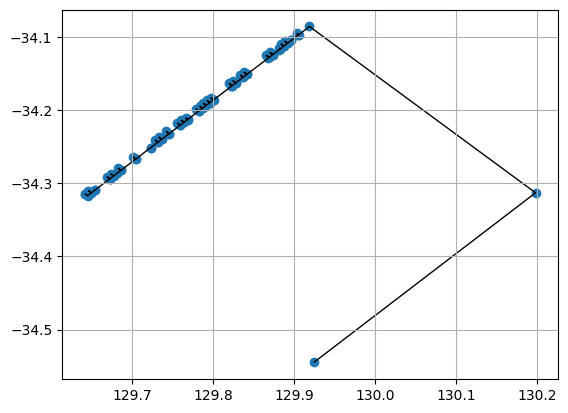

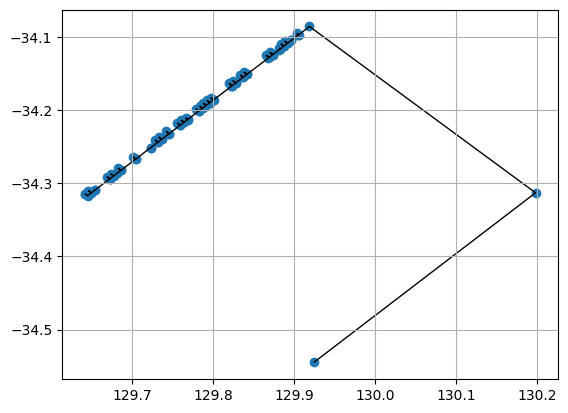

In [39]:
""" Visualize geometry """

print(f"Working on cube: {df_to_explore.cube_related_gemometry_id.iloc[index]}")
custom_cube_geopmetry_record = [record for record in osdu_cutom_geometry_records if get_attribute(record, "id") == df_to_explore.cube_related_gemometry_id.iloc[index]][0]
geometry_json = geometry_to_json(custom_cube_geopmetry_record)
validated_geometry_json = validate_geometry_polygon(geometry_json)  # returns the original geometry if not able to be fixed

plot_polygon(get_polygon_array(geometry_json))
plot_polygon(get_polygon_array(validated_geometry_json[0]))

In [701]:
"""Let'spatch the geometry and see if the indexing works"""

record_storage_updated = record_storage.copy()

attr_to_patch = get_attribute(record_storage_updated, "data.LiveTraceOutline")
polygon = get_attribute(attr_to_patch, "Wgs84Coordinates.features")[0].get("geometry").get("coordinates")[0]
fixed_polygon = fix_polygon(polygon)

attr_to_patch["Wgs84Coordinates"]["features"][0]['geometry']['coordinates'][0] = fixed_polygon

record_storage_updated["data"]["LiveTraceOutline"] = attr_to_patch
record_storage_updated["data"]["SpatialArea"] = attr_to_patch

osdu_client.app_put_returning_json("storage/v2/records", [record_storage_updated])

{'recordCount': 1,
 'recordIds': ['npequinor-dev:work-product-component--SeismicTraceData:1505713521'],
 'skippedRecordIds': [],
 'recordIdVersions': ['npequinor-dev:work-product-component--SeismicTraceData:1505713521:1690210979959587']}

In [13]:
df_non_fixable = df[(df.is_original_valid==False) & (df.is_fixable_flag == False)]
df_non_fixable.head()

,cube_related_gemometry_id,coordinate_pairs,unique_coordinate_pairs,is_original_valid,is_fixable_flag,is_invalid_flag,related_dataset_id,related_seismictrace_id
1490,npequinor-dev:poststackcubegeometries:1657863747,NaN,NaN,False,False,True,npequinor-dev:seismicpoststackdatasets:31367077,npequinor-dev:work-product-component--SeismicT...
10651,npequinor-dev:poststackcubegeometries:1657865887,NaN,NaN,False,False,True,npequinor-dev:seismicpoststackdatasets:466285738,npequinor-dev:work-product-component--SeismicT...
14796,npequinor-dev:poststackcubegeometries:1657851585,3.0,2.0,False,False,True,npequinor-dev:seismicpoststackdatasets:1167115772,npequinor-dev:work-product-component--SeismicT...
14829,npequinor-dev:poststackcubegeometries:1657850526,3.0,2.0,False,False,True,npequinor-dev:seismicpoststackdatasets:1091604943,npequinor-dev:work-product-component--SeismicT...
14890,npequinor-dev:poststackcubegeometries:1657850512,3.0,2.0,False,False,True,npequinor-dev:seismicpoststackdatasets:1091186784,npequinor-dev:work-product-component--SeismicT...


In [14]:


print(
    f"""
    Poststack cube geometry records to report to landmark: {list(set([id.rsplit(":", maxsplit=1)[-1] for id in df_non_fixable.cube_related_gemometry_id.to_list()]))}
    """
)


    Poststack cube geometry records to report to landmark: ['1657851536', '1506062186', '1506593131', '1506933573', '1657863747', '1506805217', '1506950999', '1506661620', '1506516163', '1657851549', '1507061352', '1657851585', '1506603035', '1506122973', '1657850512', '1506474669', '1657850515', '1506567460', '1506623685', '1506755531', '1506599073', '1657851600', '1506512188', '1506716831', '1507078954', '1507015526', '1506413987', '1657865887', '1657851596', '1506870515', '1507119744', '1506483291', '1506929607', '1506175367', '1505844135', '1506698929', '1657850522', '1507154712', '1506425503', '1657851604', '1506540257', '1507137228', '1505913336', '1507065318', '1507090509', '1506681997', '1506912125', '1506495859', '1657850530', '1657850526', '1506536293', '1505802206', '1506972269', '1657851610']
    
